# Final Product: Hit Success Analysis
## Part 1: Read Data

In [1]:
import os
import numpy as np
import json
import pandas as pd

In [2]:
# Read Data
hits_folder_path = '/Users/tiffanynguyen/wsd-data/wsd-hits'
no_hits_folder_path = '/Users/tiffanynguyen/wsd-data/wsd-nohit'
data = []

for filename in os.listdir(hits_folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(hits_folder_path, filename)
        with open(file_path, 'r') as json_file:
            data.append(json.load(json_file))

for filename in os.listdir(no_hits_folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(no_hits_folder_path, filename)
        with open(file_path, 'r') as json_file:
            data.append(json.load(json_file))

In [3]:
#initialize dataframe
df = pd.DataFrame(columns=["Hit Type", "Pitch Type", "Pitch Speed"])

# categorize ground balls, line drives, power, pop ups
# exit velocity will tell if the ball was hard hit or not
"""
Ground ball: Lower than 10 degrees
Line drive: 10-25 degrees
Fly ball: 25-50 degrees
Pop up: Higher than 50 degrees
"""
nons = []
count = 0
# maybe - also if passed boundary 
def classify_hit_type(data):
    hit_type = 'none'
    #check null cases
    if ('summary_acts' in data and 'hit' in data['summary_acts'] and 'speed' in data['summary_acts']['hit'] and
    'events' in data and len(data['events']) != 0 and 'start' in data['events'][0]):
        if data['summary_acts']['pitch']['result'] == "HitIntoPlay":
            # pop up
            if(data['events'][0]['start']['angle'][1] >= 50 ):
                hit_type = 'Pop Up'
                
            # power hit or pop fly depending on exit velocity
            if((data['events'][0]['start']['angle'][1] > 25 and data['events'][0]['start']['angle'][1] < 50 )):
                if (data['summary_acts']['hit']['speed']['mph'] >= 95):
                    hit_type = 'Power'
                else: 
                    hit_type = 'Fly Ball'
                    

            # line drives: hard hit vs lightly hit
            if((data['events'][0]['start']['angle'][1] >= 10 and data['events'][0]['start']['angle'][1] <= 25 )):
                if (data['summary_acts']['hit']['speed']['mph'] >= 95):
                    hit_type = 'Hard Hit Line Drive'
                else: 
                    hit_type = 'Light Line Drive'
    
            # ground balls: hard hit vs lightly hit
            elif (data['events'][0]['start']['angle'][1] < 10 ):
                if (data['summary_acts']['hit']['speed']['mph'] >= 95):
                    hit_type = 'Hard Hit Ground Ball'
                else: 
                    hit_type = 'Light Ground Ball'
    elif data['summary_acts']['pitch']['result'] == "Strike":
        hit_type = 'Strike'
    return hit_type


#read files
for cur_data in data:
    row = {
        "Hit Type" : classify_hit_type(cur_data),
        "Pitch Type" : cur_data['summary_acts']['pitch']['type'],
        "Pitch Speed" : cur_data['summary_acts']['pitch']['speed']['mph']
    }
    if (row["Hit Type"] != 'none'
        and row["Pitch Type"] is not None and len(row["Pitch Type"]) > 0
        and row["Pitch Speed"] is not None):
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

df["Good"] = ~(df["Hit Type"] == "Power") & ~(df["Hit Type"] == "Hard Hit Line Drive") & ~(df["Hit Type"] == "Fly Ball") & ~(df["Hit Type"] == "Hard Hit Ground Ball")

/var/folders/ck/w49wycq96pvcx0hxmdh1ng880000gn/T/ipykernel_48131/1502914517.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


In [4]:
display(df)

Hit Type        Pitch Type  Pitch Speed  Good
0               Strike            Slider         84.0  True
1               Strike         Curveball         79.0  True
2               Strike         Curveball         78.0  True
3    Light Ground Ball            Sinker         94.0  True
4               Strike         Curveball         79.0  True
..                 ...               ...          ...   ...
148             Strike            Sinker         90.0  True
149             Strike  FourSeamFastball         91.0  True
150             Strike          Changeup         84.0  True
151             Strike         Curveball         77.0  True
152             Strike            Slider         81.0  True

[153 rows x 4 columns]

## Part 2: Data Visualization of Trends
### Pitch Type and Hit Type Heatmap

In [5]:
import plotly.express as px

In [6]:
count_df = df.groupby(['Hit Type', 'Pitch Type']).size().reset_index(name='count')
pivot_df = count_df.pivot(index='Hit Type', columns='Pitch Type', values='count').fillna(0)

display(pivot_df)

Pitch Type            Changeup  Curveball  Cutter  FourSeamFastball  Sinker  \
Hit Type                                                                      
Fly Ball                   1.0        0.0     0.0               2.0     2.0   
Hard Hit Ground Ball       1.0        1.0     1.0               3.0     4.0   
Hard Hit Line Drive        1.0        0.0     0.0               1.0     1.0   
Light Ground Ball          3.0        1.0     0.0               1.0     3.0   
Light Line Drive           0.0        1.0     1.0               3.0     1.0   
Pop Up                     1.0        0.0     0.0               0.0     1.0   
Power                      0.0        0.0     0.0               0.0     1.0   
Strike                    12.0       16.0     7.0              13.0    35.0   

Pitch Type            Slider  
Hit Type                      
Fly Ball                 2.0  
Hard Hit Ground Ball     2.0  
Hard Hit Line Drive      0.0  
Light Ground Ball        1.0  
Light Line Drive         1.0  
Pop Up                   2.0  
Power                    1.0  
Strike                  26.0

In [ ]:
fig = px.imshow(pivot_df, text_auto=True, aspect="auto",
                labels=dict(x="Pitch Type", y="Hit Type", color="Count"),
                title="Heatmap of Hit Type vs Pitch Type",
                width=600,
                height=500,
                color_continuous_scale=px.colors.sequential.Rainbow)
fig.show()

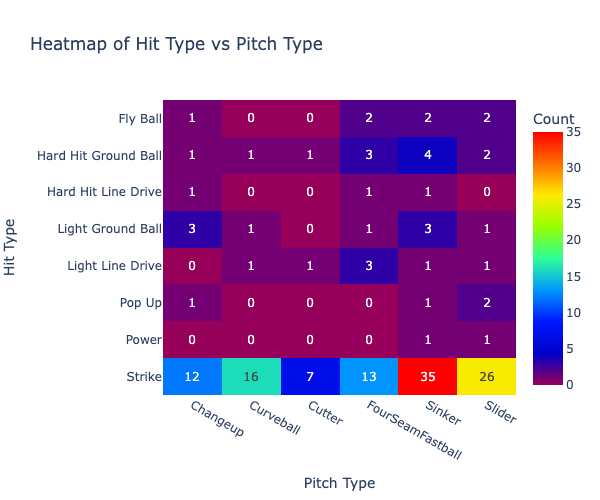
Note: Plotly images have been imported to be automatically displayed in the Jupyter notebook. However, you can also run the code to generate the graphs yourself

### Hit Type and Pitch Speed Histogram

In [ ]:
fig = px.histogram(df, x="Pitch Speed", color="Hit Type", title="Pitch Speed by Hit Type")
fig.update_xaxes(title_text="Spin (rpm)")
fig.show()

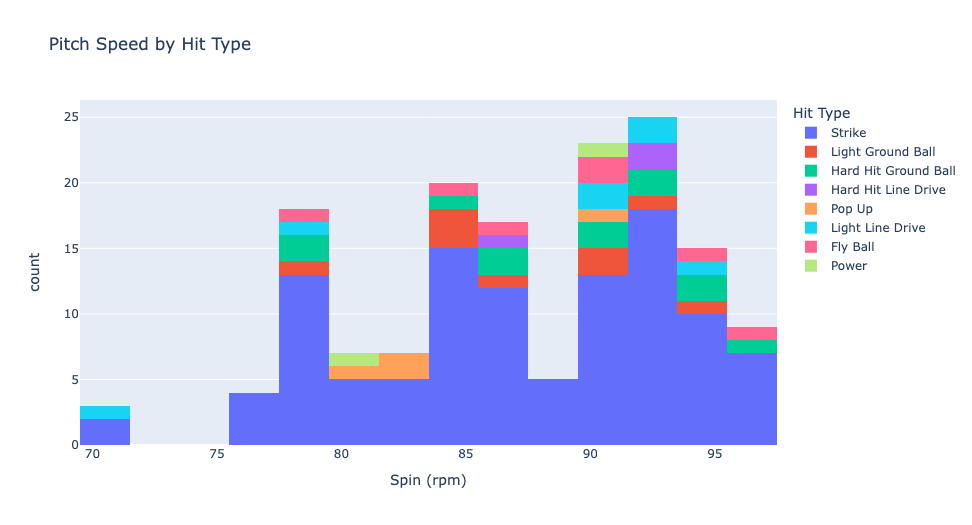

## Part 3: Predicting Good vs Bad Result for the Pitcher
Initially, we were planning to predict hit type given data such as pitch type and pitch speed. However, due to our limited sample size, we chose to simplify our analysis to predict just good and bad hits.
Here, we chose to classify a good result for the pitcher as a pitch that results in a strike, light ground ball,  light line drive, and pop up. Meanwhile, a bad result is a power hit, hard hit line drive, fly ball, and hard hit ground ball. 

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
#Label Encoder to handle string data in type
label_encoder = LabelEncoder()
df['Pitch Type Encoded'] = label_encoder.fit_transform(df['Pitch Type'])
display(df)

Hit Type        Pitch Type  Pitch Speed  Good  \
0               Strike            Slider         84.0  True   
1               Strike         Curveball         79.0  True   
2               Strike         Curveball         78.0  True   
3    Light Ground Ball            Sinker         94.0  True   
4               Strike         Curveball         79.0  True   
..                 ...               ...          ...   ...   
148             Strike            Sinker         90.0  True   
149             Strike  FourSeamFastball         91.0  True   
150             Strike          Changeup         84.0  True   
151             Strike         Curveball         77.0  True   
152             Strike            Slider         81.0  True   

     Pitch Type Encoded  
0                     5  
1                     1  
2                     1  
3                     4  
4                     1  
..                  ...  
148                   4  
149                   3  
150                   0  
151                   1  
152                   5  

[153 rows x 5 columns]

In [11]:
#divide data
features = df[["Pitch Type Encoded", "Pitch Speed"]]
target = df["Good"]
train_x, test_x, train_y, test_y = train_test_split(features, target, test_size=0.2, random_state=38) #40, 38

Accuracy: 0.87


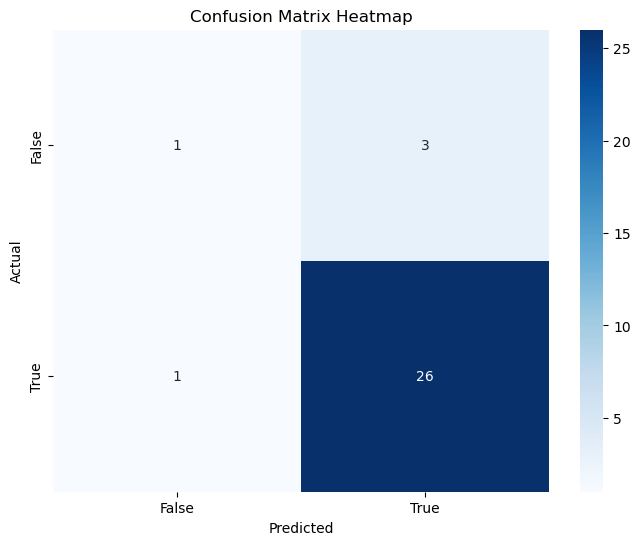

In [12]:
# Initialize and train the classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(train_x, train_y)

pred_y = classifier.predict(test_x)
accuracy = accuracy_score(test_y, pred_y)
print(f"Accuracy: {accuracy:.2f}")

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_y, pred_y)

result_data_options = sorted(list(set(df["Good"])))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=result_data_options,
            yticklabels=result_data_options)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')

plt.show()

# Other Useful Visualization
## Pitch Type to Outcome Heatmap

In [13]:
pitch_type_data = []
pitch_result_data = []
for cur_data in data:
    if(cur_data['summary_acts']['pitch']['type'] and cur_data['summary_acts']['pitch']['result']):
        pitch_type_data.append(cur_data['summary_acts']['pitch']['type'])
        pitch_result_data.append(cur_data['summary_acts']['pitch']['result'])

In [14]:
pitch_type_types = list(set(pitch_type_data))
pitch_result_types = list(set(pitch_result_data))
print("Pitch Types:", pitch_type_types)
print("Pitch Results:", pitch_result_types)

Pitch Types: ['FourSeamFastball', 'Cutter', 'Changeup', 'Curveball', 'Sinker', 'Slider']
Pitch Results: ['HitIntoPlay', 'Ball', 'Strike']


In [15]:
pitch_matrix = np.zeros([len(pitch_type_types), len(pitch_result_types)])
for i in range(len(pitch_type_data)):
    pitch_matrix[pitch_type_types.index(pitch_type_data[i])][pitch_result_types.index(pitch_result_data[i])] += 1
# print(pitch_matrix)

#convert to dictionary
type_result_dict = {'Pitch Type': pitch_type_types}
for i, outcome in enumerate(pitch_result_types):
    type_result_dict[outcome] = pitch_matrix[:, i].tolist()
# print(type_result_dict)

#Make dataframe
type_result_df = pd.DataFrame(type_result_dict)
# display(type_result_df)

# Melt the DataFrame to have a column for the pitch type and its corresponding values
melted_df = pd.melt(type_result_df, id_vars='Pitch Type', var_name='Outcome', value_name='Count')
# display(melted_df)

In [ ]:
# Create a heatmap 
fig = px.imshow(melted_df.pivot(index='Pitch Type', columns='Outcome', values='Count'),
                x=melted_df['Outcome'].unique(),
                y=melted_df['Pitch Type'].unique(),
                labels=dict(x='Outcome', y='Pitch Type', color='Count'),
                title='Pitch Type Outcome Counts',
                width=450,
                height=500, 
                text_auto=True)

fig.show()

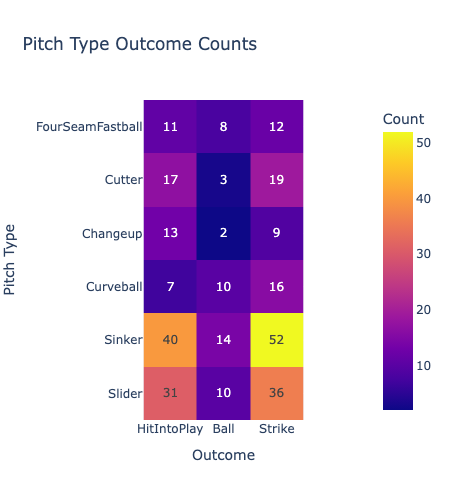

## Pitch Type to Action Heatmap

In [17]:
pitch_type_data = []
pitch_action_data = []
for cur_data in data:
    if(cur_data['summary_acts']['pitch']['type'] and cur_data['summary_acts']['pitch']['action']):
        pitch_type_data.append(cur_data['summary_acts']['pitch']['type'])
        pitch_action_data.append(cur_data['summary_acts']['pitch']['action'])

In [18]:
pitch_type_types = list(set(pitch_type_data))
pitch_action_types = list(set(pitch_action_data))
print("Pitch Types:", pitch_type_types)
print("Pitch Action:", pitch_action_types)

Pitch Types: ['FourSeamFastball', 'Cutter', 'Changeup', 'Curveball', 'Sinker', 'Slider']
Pitch Action: ['Foul', 'Called', 'Blocked', 'HitByPitch', 'FoulTip', 'BallInDirt']


In [19]:
pitch_type_action_matrix = np.zeros([len(pitch_type_types), len(pitch_action_types)])
for i in range(len(pitch_type_data)):
    pitch_type_action_matrix[pitch_type_types.index(pitch_type_data[i])][pitch_action_types.index(pitch_action_data[i])] += 1

#convert to dictionary
type_action_dict = {'Pitch Type': pitch_type_types}
for i, outcome in enumerate(pitch_action_types):
    type_action_dict[outcome] = pitch_type_action_matrix[:, i].tolist()

#Make dataframe
type_action_df = pd.DataFrame(type_action_dict)

# Melt the DataFrame to have a column for the pitch type and its corresponding values
melted_type_action_df = pd.melt(type_action_df, id_vars='Pitch Type', var_name='Pitch Action', value_name='Count')
# display(melted_type_action_df)

In [ ]:
# Create a heatmap 
fig = px.imshow(melted_type_action_df.pivot(index='Pitch Type', columns='Pitch Action', values='Count'),
                x=melted_type_action_df['Pitch Action'].unique(),
                y=melted_type_action_df['Pitch Type'].unique(),
                labels=dict(x='Pitch Action', y='Pitch Type', color='Count'),
                title='Pitch Type Action Counts',
                width=450,
                height=500, 
                text_auto=True)

fig.show()

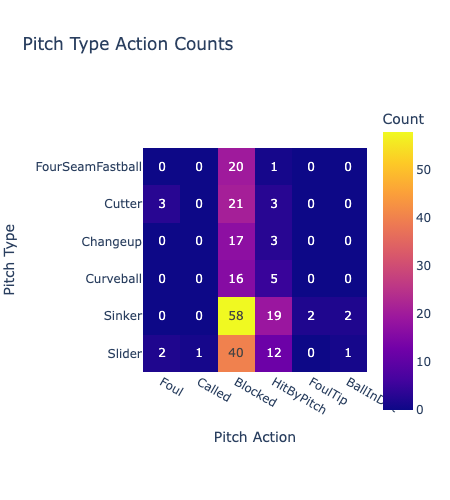

## Pitch Type By Inning Number

In [21]:
pitch_type_data = []
inning_num_data = []
for cur_data in data:
    if(cur_data['summary_acts']['pitch']['type'] and cur_data['summary_score']['runs']['innings']):
        pitch_type_data.append(cur_data['summary_acts']['pitch']['type'])
        inning_num_data.append(len(cur_data['summary_score']['runs']['innings']))

In [22]:
pitch_type_types = list(set(pitch_type_data))
inning_num_types = list(set(inning_num_data))
print("Pitch Types:", pitch_type_types)
print("Innings:", inning_num_types)

Pitch Types: ['FourSeamFastball', 'Cutter', 'Changeup', 'Curveball', 'Sinker', 'Slider']
Innings: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [23]:
pitch_type_inning_matrix = np.zeros([len(pitch_type_types), len(inning_num_types)])
for i in range(len(pitch_type_data)):
    pitch_type_inning_matrix[pitch_type_types.index(pitch_type_data[i])][inning_num_types.index(inning_num_data[i])] += 1

#convert to dictionary
pitch_type_inning_dict = {'Pitch Type': pitch_type_types}
for i, outcome in enumerate(inning_num_types):
    pitch_type_inning_dict[outcome] = pitch_type_inning_matrix[:, i].tolist()

#Make dataframe
pitch_type_inning_df = pd.DataFrame(pitch_type_inning_dict)

# Melt the DataFrame to have a column for the pitch type and its corresponding values
melted_pitch_type_inning_df = pd.melt(pitch_type_inning_df, id_vars='Pitch Type', var_name='Inning Num', value_name='Count')
# display(melted_pitch_type_inning_df)

In [ ]:
# Create a heatmap
fig = px.imshow(melted_pitch_type_inning_df.pivot(index='Pitch Type', columns='Inning Num', values='Count'),
                x=melted_pitch_type_inning_df['Inning Num'].unique(),
                y=melted_pitch_type_inning_df['Pitch Type'].unique(),
                labels=dict(x='Inning Num', y='Pitch Type', color='Count'),
                title='Pitch Type by Inning Number Counts',
                width=700,
                height=500, 
                text_auto=True)

# Show the plot
fig.show()

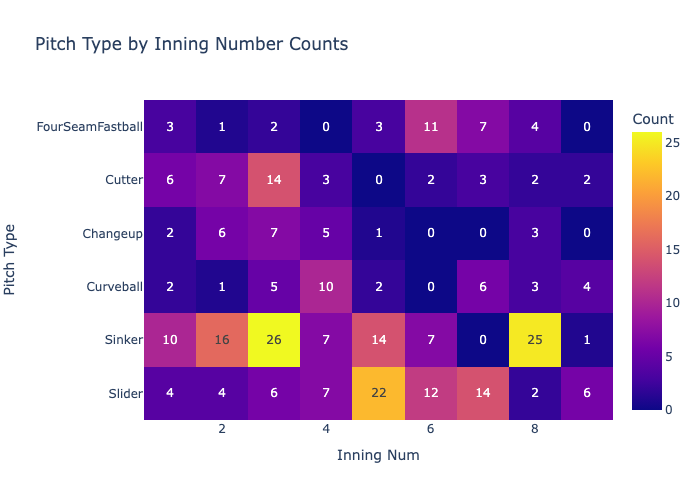

## Ball Location When Entering Strikezone
Lines indicate estimated expected strikezone (https://www.reddit.com/r/Sabermetrics/comments/kw5lfi/plate_coordinates_for_strikezone_in_statcast/), though it may vary by person

In [25]:
# Read Data
hits_folder_path = '/Users/tiffanynguyen/wsd-data/wsd-hits'
no_hits_folder_path = '/Users/tiffanynguyen/wsd-data/wsd-nohit'
data = []

for filename in os.listdir(hits_folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(hits_folder_path, filename)
        with open(file_path, 'r') as json_file:
            data.append(json.load(json_file))

for filename in os.listdir(no_hits_folder_path):
    if filename.endswith('.jsonl'):
        file_path = os.path.join(no_hits_folder_path, filename)
        with open(file_path, 'r') as json_file:
            data.append(json.load(json_file))

In [26]:
df = pd.DataFrame(columns=["Pitch Type", "Pitch Result", "First Strikezone Coordinates"])

strikezone_x_range = (-0.71, 0.71) 
strikezone_y_range = (1.17, 3.92)
padding = 1

for cur_data in data:
    if(cur_data['summary_acts']['pitch']['type'] and cur_data['summary_acts']['pitch']['result']):
        row = {
            "Pitch Type" : cur_data['summary_acts']['pitch']['type'],
            "Pitch Result": cur_data['summary_acts']['pitch']['result'],
            "First Strikezone Coordinates" : next((point['pos'] for point in cur_data['samples_ball'] if strikezone_x_range[0] - padding <= point['pos'][0] <= strikezone_x_range[1] + padding and strikezone_y_range[0] - padding <= point['pos'][1] <= strikezone_y_range[1] + padding), None)
        }
        if (row["First Strikezone Coordinates"] is not None):
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

In [27]:
df[['x', 'y', 'z']] = pd.DataFrame(df['First Strikezone Coordinates'].tolist(), index=df.index)
display(df)

Pitch Type Pitch Result  \
0       Slider       Strike   
1       Slider         Ball   
2    Curveball       Strike   
3    Curveball       Strike   
4       Sinker  HitIntoPlay   
..         ...          ...   
288     Slider         Ball   
289     Slider       Strike   
290  Curveball         Ball   
291     Cutter         Ball   
292     Sinker         Ball   

                          First Strikezone Coordinates         x         y  \
0    [0.2997477411116447, 4.4995963761198805, 1.866...  0.299748  4.499596   
1    [1.0249316702132467, 2.9747416030028013, 2.294...  1.024932  2.974742   
2    [1.5565600522949354, 4.768960763222131, 1.8162...  1.556560  4.768961   
3    [-0.13251148498640544, 1.6720313898055859, 2.7... -0.132511  1.672031   
4    [-0.2489885715754057, 0.4018491555324212, 2.99... -0.248989  0.401849   
..                                                 ...       ...       ...   
288  [-1.6279900204598183, 1.6439404343979873, 3.37... -1.627990  1.643940   
289  [-0.3690704896859717, 4.38302345611981, 2.5867... -0.369070  4.383023   
290  [-0.5339206452302998, 2.4949821189084336, 0.38... -0.533921  2.494982   
291  [-0.007477829975451711, 3.0602570662636115, 1.... -0.007478  3.060257   
292  [-1.1314191831181333, 4.033225400794952, 3.659... -1.131419  4.033225   

            z  
0    1.866213  
1    2.294144  
2    1.816300  
3    2.738673  
4    2.998741  
..        ...  
288  3.371410  
289  2.586718  
290  0.381714  
291  1.178303  
292  3.659130  

[293 rows x 6 columns]

In [ ]:
# Create scatter plot
fig = px.scatter(
    df, 
    x='x', 
    y='y', 
    color='Pitch Result',
    labels={'x': 'X Coordinate', 'y': 'Y Coordinate'},
    width=600,
    height=500,
    title='Strikezone Location by Result'
)

#Lines for Strikezone
fig.add_shape( type='line', x0=-0.71, y0=df['y'].min(), x1=-0.71,y1=df['y'].max(),line=dict(color='Red',width=2))
fig.add_shape( type='line', x0=0.71, y0=df['y'].min(), x1=0.71,y1=df['y'].max(),line=dict(color='Red',width=2))
fig.add_shape( type='line', x0=df['x'].min(), y0=1.17, x1=df['x'].max(), y1=1.17,line=dict(color='Red',width=2))
fig.add_shape( type='line', x0=df['x'].min(), y0=3.92, x1=df['x'].max(), y1=3.92,line=dict(color='Red',width=2))


# Show plot
fig.show()

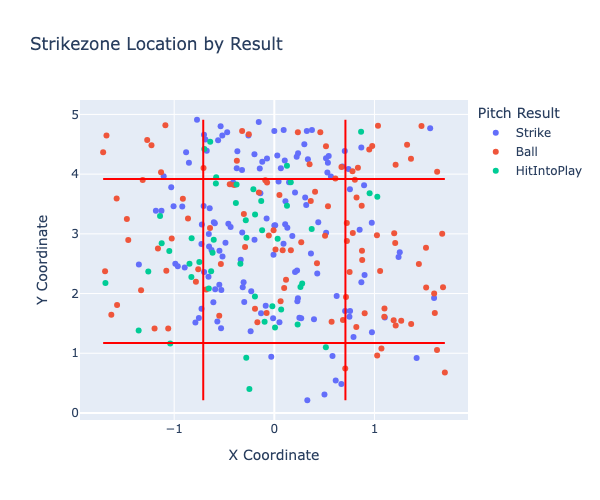

In [ ]:
# Create scatter plot
fig = px.scatter(
    df, 
    x='x', 
    y='y', 
    color='Pitch Type',
    labels={'x': 'X Coordinate', 'y': 'Y Coordinate'},
    width=600,
    height=500,
    title='Strikezone Location by Type'
)

#Lines for Strikezone
fig.add_shape( type='line', x0=-0.71, y0=df['y'].min(), x1=-0.71,y1=df['y'].max(),line=dict(color='Red',width=2))
fig.add_shape( type='line', x0=0.71, y0=df['y'].min(), x1=0.71,y1=df['y'].max(),line=dict(color='Red',width=2))
fig.add_shape( type='line', x0=df['x'].min(), y0=1.17, x1=df['x'].max(), y1=1.17,line=dict(color='Red',width=2))
fig.add_shape( type='line', x0=df['x'].min(), y0=3.92, x1=df['x'].max(), y1=3.92,line=dict(color='Red',width=2))

# Show plot
fig.show()

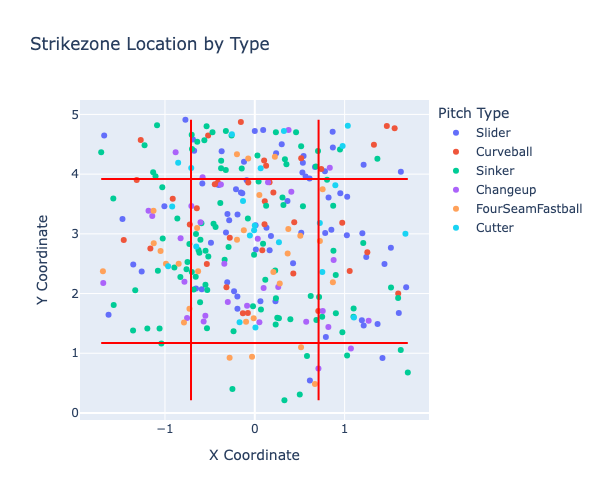

## Pitch Initial Speed and Spin Frequency by Type

In [33]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly

In [34]:
pitch_speed = [[] for _ in range(len(pitch_type_types))]

for cur_data in data:
    if(cur_data['summary_acts']['pitch']['type'] and cur_data['summary_acts']['pitch']['speed']['mph']):
        index = pitch_type_types.index(cur_data['summary_acts']['pitch']['type'])
        pitch_speed[index].append(cur_data['summary_acts']['pitch']['speed']['mph'])

In [ ]:
# Overlay
fig = go.Figure()
for i in range(len(pitch_type_types)):
    fig.add_trace(go.Histogram(x=pitch_speed[i], name=pitch_type_types[i]))

# Overlay both histograms
fig.update_layout(barmode='overlay', title_text='Pitch Initial Speed Frequency')
fig.update_xaxes(title_text="Speed (mph)")
fig.update_yaxes(title_text="Frequency")

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

# fig.write_image("Pitch Initial Speed Frequency Histogram.png", engine='kaleido')

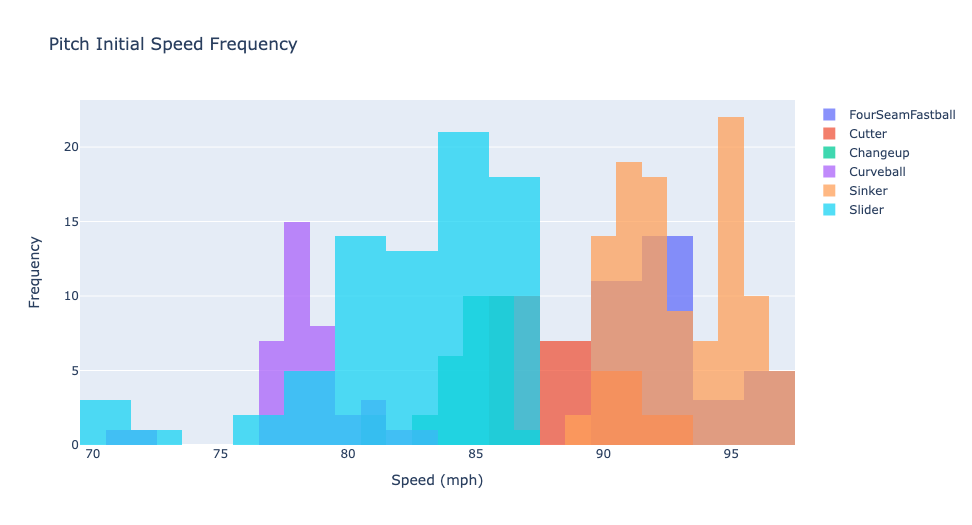

In [36]:
pitch_spin = [[] for _ in range(len(pitch_type_types))]

for cur_data in data:
    if(cur_data['summary_acts']['pitch']['type'] and cur_data['summary_acts']['pitch']['spin']['rpm']):
        index = pitch_type_types.index(cur_data['summary_acts']['pitch']['type'])
        pitch_speed[index].append(cur_data['summary_acts']['pitch']['spin']['rpm'])

In [ ]:
# Overlay
fig = go.Figure()
for i in range(len(pitch_type_types)):
    fig.add_trace(go.Histogram(x=pitch_speed[i], name=pitch_type_types[i]))
    
# Overlay both histograms
fig.update_layout(barmode='overlay', title_text='Pitch Initial Spin Frequency')
fig.update_xaxes(title_text="Spin (rpm)")
fig.update_yaxes(title_text="Frequency")

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

# fig.write_image("Pitch Initial Spin Frequency Histogram.png", engine='kaleido')

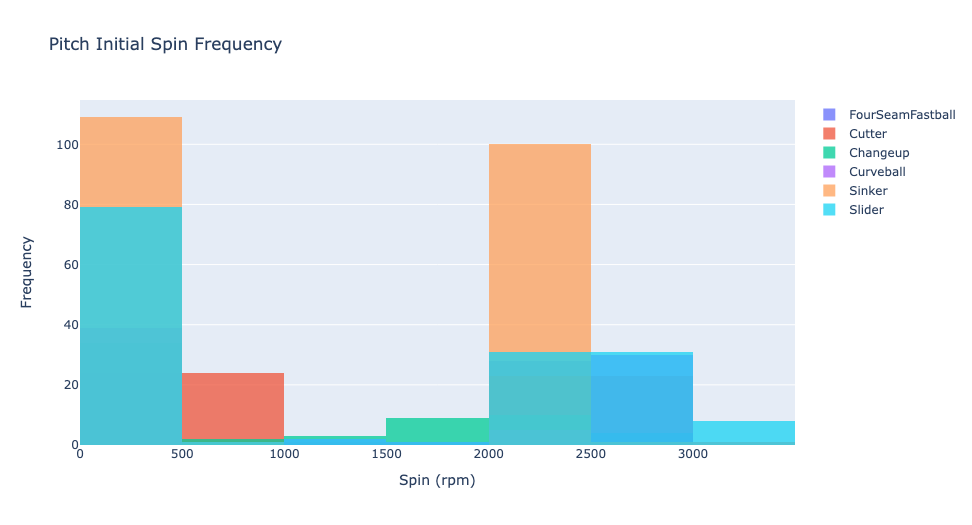

## Pitch Speed and Spin by Result
Initially, we were planning to predict the result based on the pitch type, speed, and spin. After performing these visualizations, however, we realized that there was not a strong correlation between pitch speed/spin and result

In [38]:
speed_result_list = []

for cur_data in data:
    speed = cur_data['summary_acts']['pitch']['speed']['mph']
    result = cur_data['summary_acts']['pitch']['result']
    
    if speed != "" and result != "":
        cur_row = {
            "Speed": speed,
            "Result": result
        }
        speed_result_list.append(cur_row)

speed_result_df = pd.DataFrame(speed_result_list)

# display(speed_result_df)

In [ ]:
fig = px.histogram(speed_result_df, x="Speed", color="Result", title="Pitch Speed Distribution by Result")
fig.update_xaxes(title_text="Speed (mph)")
fig.show()

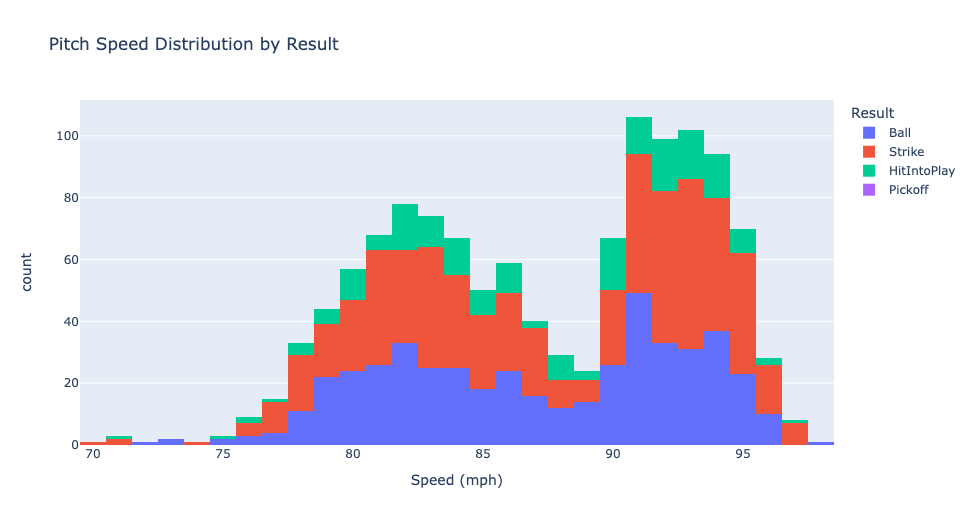

In [40]:
spin_result_list = []

for cur_data in data:
    spin = cur_data['summary_acts']['pitch']['spin']['rpm']
    result = cur_data['summary_acts']['pitch']['result']
    
    if spin != "" and result != "":
        cur_row = {
            "Spin": spin,
            "Result": result
        }
        spin_result_list.append(cur_row)

spin_result_df = pd.DataFrame(spin_result_list)

# display(spin_result_df)

In [ ]:
fig = px.histogram(spin_result_df, x="Spin", color="Result", title="Pitch Spin Distribution by Result")
fig.update_xaxes(title_text="Spin (rpm)")
fig.show()

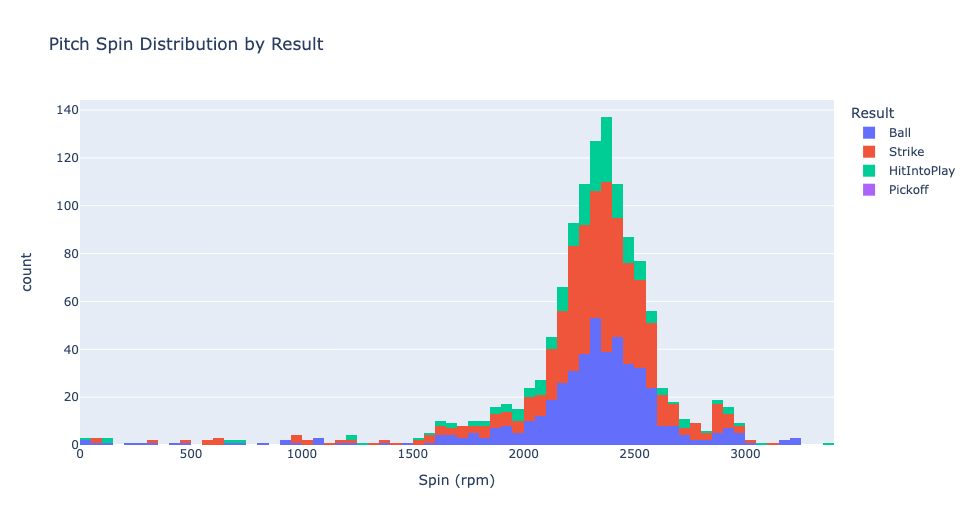

## Ball Path 3D Visualization
### Close-up Near Hit

In [42]:
import bisect
import heapq
import ipywidgets as widgets

In [43]:
#Read data
file = open('json_files/12345645_40081.jsonl')
data = json.load(file)

ball_pos = list((object['pos'] for object in data['samples_ball'])) 
ball_time = list((object['time'] for object in data['samples_ball']))

bat_time = list((object['time'] for object in data['samples_bat'])) 
bat_head_pos = list((object['head']['pos'] for object in data['samples_bat'])) 
bat_handle_pos = list((object['handle']['pos'] for object in data['samples_bat'])) 

In [44]:
#Check length (to make sure there's a time attached to each)
print(len(ball_pos), len(ball_time), len(bat_time), len(bat_head_pos), len(bat_handle_pos))
print(min(ball_time), max(ball_time))
print(min(bat_time), max(bat_time))

276 276 369 369 369
0.0307811 25.2087811
-0.3925578 0.8306792


In [45]:
all_time = list(heapq.merge(ball_time, bat_time)) #merge the 2 lists to get a list of all times

In [46]:
#Get min x, y, and z to set axis limits
min_bat_x = min(min(cur_pos[0] for cur_pos in bat_head_pos), min(cur_pos[0] for cur_pos in bat_handle_pos))
min_bat_y = min(min(cur_pos[1] for cur_pos in bat_head_pos), min(cur_pos[1] for cur_pos in bat_handle_pos))
min_bat_z = min(min(cur_pos[2] for cur_pos in bat_head_pos), min(cur_pos[2] for cur_pos in bat_handle_pos))
min_x = min(min_bat_x, min(cur_pos[0] for cur_pos in ball_pos))
min_y = min(min_bat_y, min(cur_pos[1] for cur_pos in ball_pos))
min_z = min(min_bat_z, min(cur_pos[2] for cur_pos in ball_pos))
print(min_x, min_y, min_z)

#Get max x, y, and z to set axis limits
max_bat_x = max(max(cur_pos[0] for cur_pos in bat_head_pos), max(cur_pos[0] for cur_pos in bat_handle_pos))
max_bat_y = max(max(cur_pos[1] for cur_pos in bat_head_pos), max(cur_pos[1] for cur_pos in bat_handle_pos))
max_bat_z = max(max(cur_pos[2] for cur_pos in bat_head_pos), max(cur_pos[2] for cur_pos in bat_handle_pos))
max_x = max(max_bat_x, max(cur_pos[0] for cur_pos in ball_pos))
max_y = max(max_bat_y, max(cur_pos[1] for cur_pos in ball_pos))
max_z = max(max_bat_z, max(cur_pos[2] for cur_pos in ball_pos))
print(max_x, max_y, max_z)

-123.02992283003434 -2.9007332616677957 0.06301153109674586
48.25335317270798 326.36468750074084 46.026410901350175


In [47]:
# Find the closest bat/ball time measurement for a passed in measurement
def get_closest_time(time, isBat):
    if (isBat):
        index = bisect.bisect_left(bat_time, time)
    else:
        index = bisect.bisect_left(ball_time, time)
        
    if index == 0:
        return 0
    return index - 1 #get time "before"

In [48]:
#Estimate close enough value by seeing how different bat handle/ball position is at hit
print(ball_pos[get_closest_time(264, False)])
print(bat_handle_pos[get_closest_time(264, True)])
difference = [a - b for a, b in zip(ball_pos[get_closest_time(264, False)], bat_handle_pos[get_closest_time(264, True)])]
print(difference)

[48.25335317270798, 3.9785945854808817, 0.08448434771116811]
[-3.279877193127228, -0.5294433594961651, 5.265283297456391]
[51.53323036583521, 4.508037944977047, -5.180798949745223]


In [49]:
#Select frames for "near hit"
start_frame = 223
end_frame = 321

bat_start = get_closest_time(all_time[start_frame], True)
bat_end = get_closest_time(all_time[end_frame], True)
ball_start = get_closest_time(all_time[start_frame], False)
ball_end = get_closest_time(all_time[end_frame], False)

In [50]:
#Adjust list to get max/min in time range: 
bat_hit_head_pos = bat_head_pos[bat_start:bat_end]
bat_hit_handle_pos = bat_handle_pos[bat_start:bat_end]
ball_hit_pos = ball_pos[ball_start:ball_end]

#Get min x, y, and z to set axis limits
min_bat_x = min(min(cur_pos[0] for cur_pos in bat_hit_head_pos), min(cur_pos[0] for cur_pos in bat_hit_handle_pos))
min_bat_y = min(min(cur_pos[1] for cur_pos in bat_hit_head_pos), min(cur_pos[1] for cur_pos in bat_hit_handle_pos))
min_bat_z = min(min(cur_pos[2] for cur_pos in bat_head_pos), min(cur_pos[2] for cur_pos in bat_hit_handle_pos))
hit_min_x = min(min_bat_x, min(cur_pos[0] for cur_pos in ball_hit_pos))
hit_min_y = min(min_bat_y, min(cur_pos[1] for cur_pos in ball_hit_pos))
hit_min_z = min(min_bat_z, min(cur_pos[2] for cur_pos in ball_hit_pos))
print(hit_min_x, hit_min_y, hit_min_z)

#Get max x, y, and z to set axis limits
max_bat_x = max(max(cur_pos[0] for cur_pos in bat_hit_head_pos), max(cur_pos[0] for cur_pos in bat_hit_handle_pos))
max_bat_y = max(max(cur_pos[1] for cur_pos in bat_hit_head_pos), max(cur_pos[1] for cur_pos in bat_hit_handle_pos))
max_bat_z = max(max(cur_pos[2] for cur_pos in bat_hit_head_pos), max(cur_pos[2] for cur_pos in bat_hit_handle_pos))
hit_max_x = max(max_bat_x, max(cur_pos[0] for cur_pos in ball_hit_pos))
hit_max_y = max(max_bat_y, max(cur_pos[1] for cur_pos in ball_hit_pos))
hit_max_z = max(max_bat_z, max(cur_pos[2] for cur_pos in ball_hit_pos))
print(hit_max_x, hit_max_y, hit_max_z)

-5.181118912076154 -2.2917995886471023 1.1384637762161678
2.4854771552711097 19.558734031102208 8.315852611139123


In [ ]:
@widgets.interact(frame=(0, end_frame - start_frame - 1))
def axial_slicer(frame=0):
    frame = frame + start_frame
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    #Plot bat
    bat_frame = get_closest_time(all_time[frame], True) #Get closest bat frame for the given time
    bat_x_values = [bat_head_pos[bat_frame][0], bat_handle_pos[bat_frame][0]]
    bat_y_values = [bat_head_pos[bat_frame][1], bat_handle_pos[bat_frame][1]]
    bat_z_values = [bat_head_pos[bat_frame][2], bat_handle_pos[bat_frame][2]]
    ax.plot(bat_x_values, bat_y_values, bat_z_values, 'r-')    
    
    #Plot ball
    ball_frame = get_closest_time(all_time[frame], False)
    ball_x_value = ball_pos[ball_frame][0]
    ball_y_value = ball_pos[ball_frame][1]
    ball_z_value = ball_pos[ball_frame][2]
    ax.scatter(ball_x_value, ball_y_value, ball_z_value, 'r')
    
    #Plot Settings
    plt.xlim(hit_min_x, hit_max_x)
    plt.ylim(hit_min_y, hit_max_y)
    ax.set_zlim(hit_min_z, hit_max_z)
    plt.title("Ball/Ball Visual Around Hit")
    plt.show()

View Here: https://github.com/mfollosco/WSD-hackathon/blob/main/pitch_graphs/BallCloseupVisual.gif

### Full Duration, Ball Changes Color Based on Velocity

In [52]:
import numpy as np
import matplotlib.colors as mcolors

In [53]:
velocity = list((sample['vel'] for sample in data['samples_ball'] if 'vel' in sample)) 
velocity_mag = list(np.linalg.norm(object) for object in velocity) 
print(len(velocity_mag), len(ball_pos))

275 276


In [54]:
min_vel = min(velocity_mag)
max_vel = max(velocity_mag)
print(min_vel, max_vel)

12.43047322780382 105.5944707612867


In [55]:
#Prepare color plot
#Normalize color values for plot
norm = mcolors.Normalize(vmin=min_vel, vmax=max_vel)

# Create a colormap
cmap = plt.get_cmap('viridis')

In [ ]:
@widgets.interact(frame=(0, len(all_time)-1))
# @widgets.interact(frame=(0, 495))
def axial_slicer(frame=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    #Plot bat
    bat_frame = get_closest_time(all_time[frame], True) #Get closest bat frame for the given time
    bat_x_values = [bat_head_pos[bat_frame][0], bat_handle_pos[bat_frame][0]]
    bat_y_values = [bat_head_pos[bat_frame][1], bat_handle_pos[bat_frame][1]]
    bat_z_values = [bat_head_pos[bat_frame][2], bat_handle_pos[bat_frame][2]]
    ax.plot(bat_x_values, bat_y_values, bat_z_values, 'r-')    
    
    #Plot ball
    ball_frame = get_closest_time(all_time[frame], False)
    ball_x_value = ball_pos[ball_frame][0]
    ball_y_value = ball_pos[ball_frame][1]
    ball_z_value = ball_pos[ball_frame][2]
    vel_color = cmap(norm(velocity_mag[ball_frame]))
    ax.scatter(ball_x_value, ball_y_value, ball_z_value, color = vel_color)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    plt.colorbar(sm, ax=plt.gca(), label='Ball Velocity (mph)')

    #Plot Settings
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    ax.set_zlim(min_z, max_z)
    plt.title("Ball Velocity Visual")
    plt.show()

View here: https://github.com/mfollosco/WSD-hackathon/blob/main/pitch_graphs/FullBallVisual.gif